In [ ]:
%pip install -r requirements.txt

In [1]:
# Imports

import steamdata
import preprocess
import pandas as pd
import database
import preprocess
from nltk import word_tokenize


#### **1) DATA ACQUISITION**

In [ ]:
# Gets top 100 -> DO NOT RUN

app_ids = steamdata.get_app_ids() # -> Retrieves best 100 of top sellers weekly chart.
steamdata.update_data() # -> Sends an API Call for each game, parses the response and saves in DB

#### **2) PRE-PROCESSING**

In [ ]:
# Gets data from database
df = database.get_data_from_database()
# Preprocess review
df = preprocess.preProcessData(df)
# Save in database clean review in additional column
database.send_to_database(df)

#### **3) EDA**

In [2]:
df = database.get_data_from_database()
df["original_review"] = df["review"]
df["review"] = [word_tokenize(string) for string in df["review"]]
df["review_clean"] = [word_tokenize(string) for string in df["review_clean"]]

In [ ]:
import visualizations
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def tokenize(reviews):
    words = word_tokenize(reviews)
    return [word for word in words if not word.lower() in stop_words]

reviews_per_game = (df.groupby("app_id")
                    .apply(lambda row: [tokenize(review) for review in row["review"]])
                    .tolist())

# TODO for final graphs:
#  Tokenize reviews and then join the tokens together -> stopwords and contractions should be resolved

for reviews in reviews_per_game:
    # join the tokens of each review
    reviews_texts = [' '.join(review) for review in reviews]
    # join the reviews
    all_reviews_for_game = ' '.join(reviews_texts)
    visualizations.visualize_wordcloud(all_reviews_for_game, False)

In [ ]:
# print most common words per game

for reviews in reviews_per_game:
    tokens_concatenated = [token for review in reviews for token in review]
    # requires list of words
    visualizations.visualize_word_count(tokens_concatenated)

In [ ]:
reviews_untokenized_per_game = (df.groupby("app_id")
                                .apply(lambda row: [review for review in row["review"]])
                                .tolist())
game_ids = (df.groupby("app_id")
            .apply(lambda row: row["app_id"])
            .unique()
            .tolist())

for reviews_untokenized, game_id in zip(reviews_untokenized_per_game, game_ids):
    visualizations.readability_scores(reviews_untokenized, "GameID: " + str(game_id))

### Words per Review Distribution

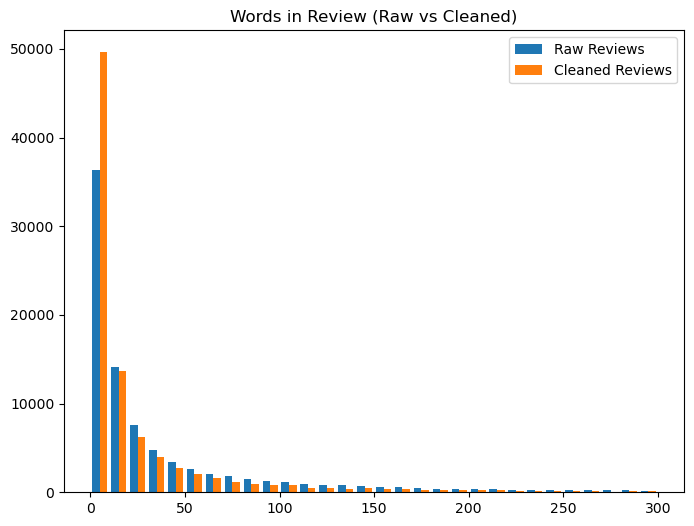

In [20]:
import visualizations
from importlib import reload

reload(visualizations)

df["#words"] = df["review"].apply(lambda word_tokens: len(word_tokens))
df["#words_clean"] = df["review_clean"].apply(lambda word_tokens: len(word_tokens))

max_words = 300

visualizations.plot_word_count_histogram([df[df["#words"] <= max_words]["#words"], df[df["#words_clean"] <= max_words]["#words_clean"]], 
                              ["Raw Reviews", "Cleaned Reviews"])

In [9]:
import textstat

df["flesch_reading_ease"] = df["original_review"].apply(lambda review: textstat.flesch_reading_ease(review))
df["automated_readability_index"] = df["original_review"].apply(lambda review: textstat.automated_readability_index(review))

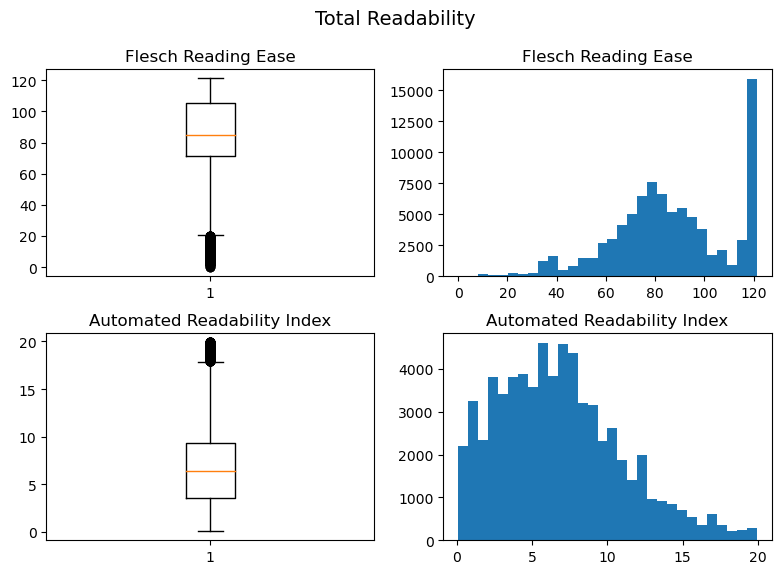

In [21]:
flesch_reading_ease = df[(df["flesch_reading_ease"] > 0) & (df["flesch_reading_ease"] < 200)]["flesch_reading_ease"]
automated_readability_index = df[(df["automated_readability_index"] > 0) & (df["automated_readability_index"] < 20)]["automated_readability_index"]

visualizations.readability_scores(flesch_reading_ease, automated_readability_index, "Total Readability")